In [1]:
import csv
import numpy as np
import pandas as pd
from math import factorial

import datetime
from datetime import date
import datetime
import time

import scipy
import os, os.path
from os import listdir
from os.path import isfile, join

import re
# from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as npc

### Set up directories

In [2]:
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/03_third_investigation/"

In [3]:
# import glob
# All files ending with .txt
# glob.glob(data_dir + "*.csv")

file_names = [x for x in os.listdir(data_dir) if x.endswith(".csv")]
file_names

['Grant_4Fields_Landsat7_T1_L2_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Sentinel_70cloud_2015-06-01_2021-07-01.csv',
 'Grant_4Fields_Landsat7_T1_SR_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat5_T1_L2_2008-01-01_2012-05-05.csv',
 'Grant_4Fields_Landsat7_8day_NDVIComposite_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat8_T1_SR_2013-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat5_T1_SR_2008-01-01_2013-06-05.csv']

In [4]:
dataframe_list = []
for curr_f in file_names:
    A = pd.read_csv(data_dir + curr_f)
    if "L2" in curr_f:
        A["dataset"] = curr_f.split("_")[2] + "_" + curr_f.split("_")[3] + "_" + curr_f.split("_")[4] + "_C2"
    elif "Sentinel" in curr_f:
        A["dataset"] = "Sentinel"
    elif "SR" in curr_f:
        A["dataset"] = curr_f.split("_")[2] + "_" + curr_f.split("_")[3] + "_" + curr_f.split("_")[4]

    A = A[A['NDVI'].notna()]
    dataframe_list.append(A)

all_data = pd.concat(dataframe_list)
all_data.reset_index(drop=True, inplace=True)
unique_fields = list(np.sort(all_data.ID.unique()))

all_data = nc.add_human_start_time_by_system_start_time(all_data)

In [5]:
all_data.head(2)

,ID,county,CropTyp,Irrigtn,LstSrvD,doy,EVI,NDVI,system_start_time,image_year,dataset,human_system_start_time
0,106054_WSDA_SF_2017,Grant,"bean, dry",center pivot,2017/06/28,4.0,-0.105867,0.019811,1.199558e+09,2008.0,Landsat7_T1_L2_C2,2008-01-05
1,104563_WSDA_SF_2017,Grant,potato,rill,2017/05/16,20.0,0.451096,-0.038306,1.200940e+09,2008.0,Landsat7_T1_L2_C2,2008-01-21


In [6]:
list(all_data.dataset.unique())

['Landsat7_T1_L2_C2',
 'Sentinel',
 'Landsat7_T1_SR',
 'Landsat5_T1_L2_C2',
 nan,
 'Landsat8_T1_SR',
 'Landsat5_T1_SR']

### Set the plotting style

In [7]:
size = 20
title_FontSize = 8
legend_FontSize = 8
tick_FontSize = 12
label_FontSize = 14

params = {'legend.fontsize': 'medium',
          'figure.figsize': (6, 4),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.6,
          'ytick.labelsize': size * 0.6,
          'axes.titlepad': 10}

#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'Palatino')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update(params)
# pylab.rcParams.update(params)
# plt.rc('text', usetex=True)

### Set the colors

In [8]:
list(np.sort(list(all_data.dataset.unique())))

['Landsat5_T1_L2_C2',
 'Landsat5_T1_SR',
 'Landsat7_T1_L2_C2',
 'Landsat7_T1_SR',
 'Landsat8_T1_SR',
 'Sentinel',
 'nan']

In [9]:
dot_s = 80

# These are the colors that will be used in the plot
color_dict = {'Sentinel': '#d62728',
              'Landsat7_T1_L2_C2': '#8c564b', 
              'Landsat7_T1_SR': 'k', # #8c564b
              'Landsat8_T1_SR': '#2ca02c',
             }

color_dict = {'Sentinel': '#d62728',
              'Landsat7_T1_L2_C2': '#8c564b', 
              'Landsat7_T1_SR': 'k', # #8c564b
              'Landsat7_T1_L2_noSnowFilter': '#ff7f0e',
              'Landsat8_T1_SR': '#2ca02c',
              'Landsat5_T1_L2_C2': '#9467bd',
              'Landsat5_T1_SR': '#e377c2'
             }
# 'Landsat7_8day_NDVIComposite': '#1f77b4',



# These are the colors that will be used in the plot
color_dict = {'Landsat7_T1_L2_C2': '#8c564b', 
              'Landsat578_T1_SR': 'k',
              'Sentinel': '#d62728'
             }

# Merge Landsat 5, 7 and 8 into one time series

In [10]:
file_names

['Grant_4Fields_Landsat7_T1_L2_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Sentinel_70cloud_2015-06-01_2021-07-01.csv',
 'Grant_4Fields_Landsat7_T1_SR_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat5_T1_L2_2008-01-01_2012-05-05.csv',
 'Grant_4Fields_Landsat7_8day_NDVIComposite_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat8_T1_SR_2013-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat5_T1_SR_2008-01-01_2013-06-05.csv']

In [11]:
dataframe_list = []

# Read Sentinel
A = pd.read_csv(data_dir + 'Grant_4Fields_Sentinel_70cloud_2015-06-01_2021-07-01.csv')
A["dataset"] = "Sentinel"
A = A[A['NDVI'].notna()]
dataframe_list.append(A)

# Read Collection 2, Level 2 of Landsat-7
A = pd.read_csv(data_dir + 'Grant_4Fields_Landsat7_T1_L2_2008-01-01_2021-07-01.csv')
A["dataset"] = "Landsat7_T1_L2_C2"
A = A[A['NDVI'].notna()]
dataframe_list.append(A)


# Read Landsat 5, 7, and 8 and merge them together

L5 = pd.read_csv(data_dir + 'Grant_4Fields_Landsat5_T1_SR_2008-01-01_2013-06-05.csv')
L5["dataset"] = "Landsat578_T1_SR"
L5 = L5[L5['NDVI'].notna()]

L7 = pd.read_csv(data_dir + 'Grant_4Fields_Landsat7_T1_SR_2008-01-01_2021-07-01.csv')
L7["dataset"] = "Landsat578_T1_SR"
L7 = L7[L7['NDVI'].notna()]

L8 = pd.read_csv(data_dir + 'Grant_4Fields_Landsat8_T1_SR_2013-01-01_2021-07-01.csv')
L8["dataset"] = "Landsat578_T1_SR"
L8 = L8[L8['NDVI'].notna()]

L78 = pd.concat([L5, L7, L8])
dataframe_list.append(L78)

In [12]:
all_data = pd.concat(dataframe_list)
all_data.reset_index(drop=True, inplace=True)
all_data = nc.add_human_start_time_by_system_start_time(all_data)

In [13]:
ID_list = list(np.sort(all_data.ID.unique()))
satellite_list = list(np.sort(all_data.dataset.unique()))

In [14]:
VI="NDVI"
interval_size = 10

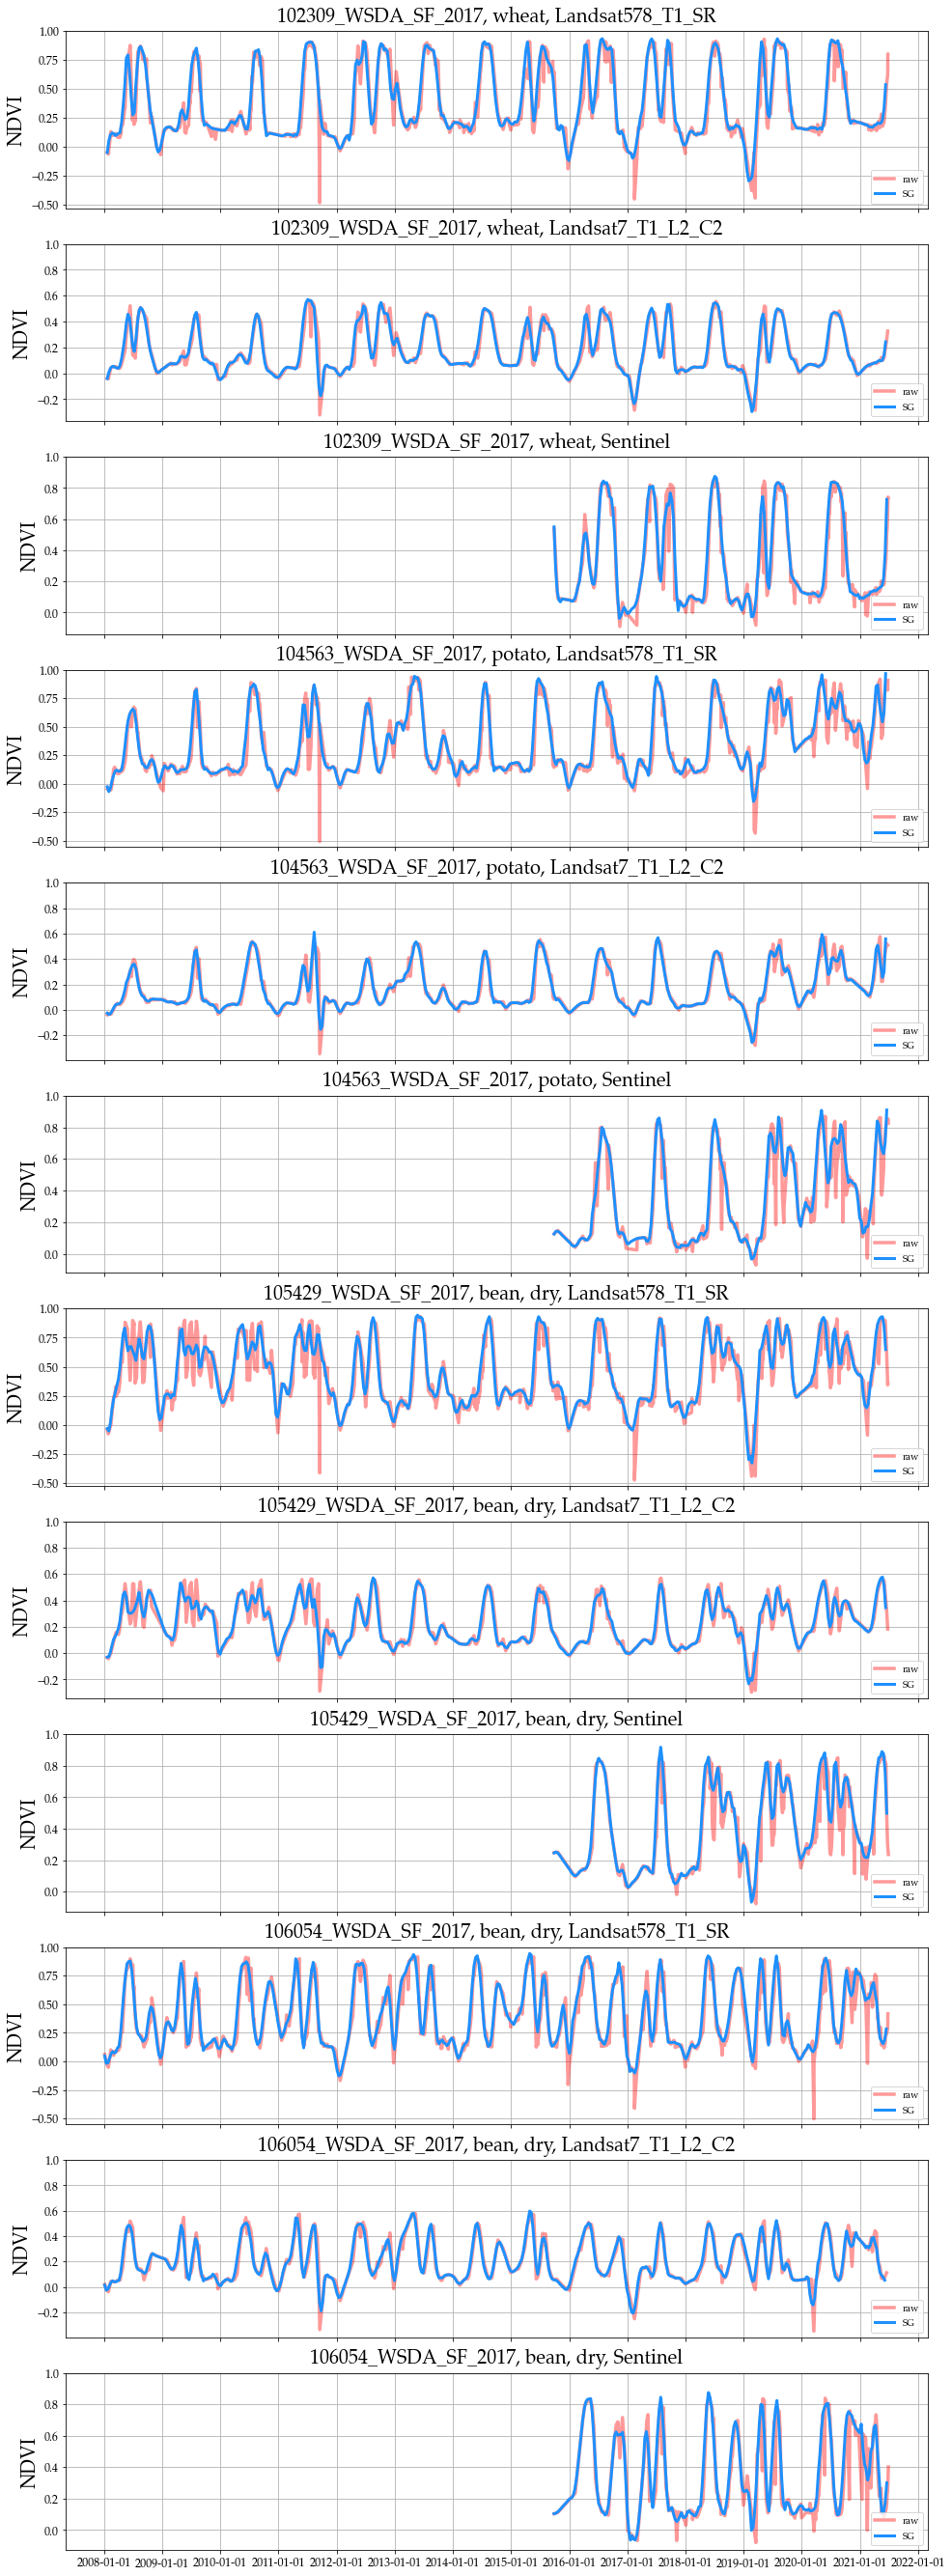

In [15]:
fig, axs = plt.subplots(12, 1, figsize=(16, 48),
                    sharex='col', sharey='row',
                    # sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0.2, 'wspace': .05});

(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12) = axs;
ax1.grid(True); ax2.grid(True)
ax3.grid(True); ax4.grid(True)

ax5.grid(True); ax7.grid(True)
ax6.grid(True); ax8.grid(True)

ax11.grid(True); ax12.grid(True)
ax9.grid(True); ax10.grid(True)

curr_raw = all_data[all_data.ID == ID_list[0]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[0]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax1, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[0]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[1]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax2, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[0]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[2]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax3, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[1]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[0]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax4, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[1]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[1]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax5, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[1]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[2]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax6, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[2]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[0]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax7, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[2]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[1]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax8, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[2]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[2]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax9, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[3]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[0]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax10, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[3]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[1]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax11, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[3]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[2]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax12, idx=VI, time_step_size=interval_size)

file_name = data_dir + "raw_figures/"+ "regularized_compare.pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False);

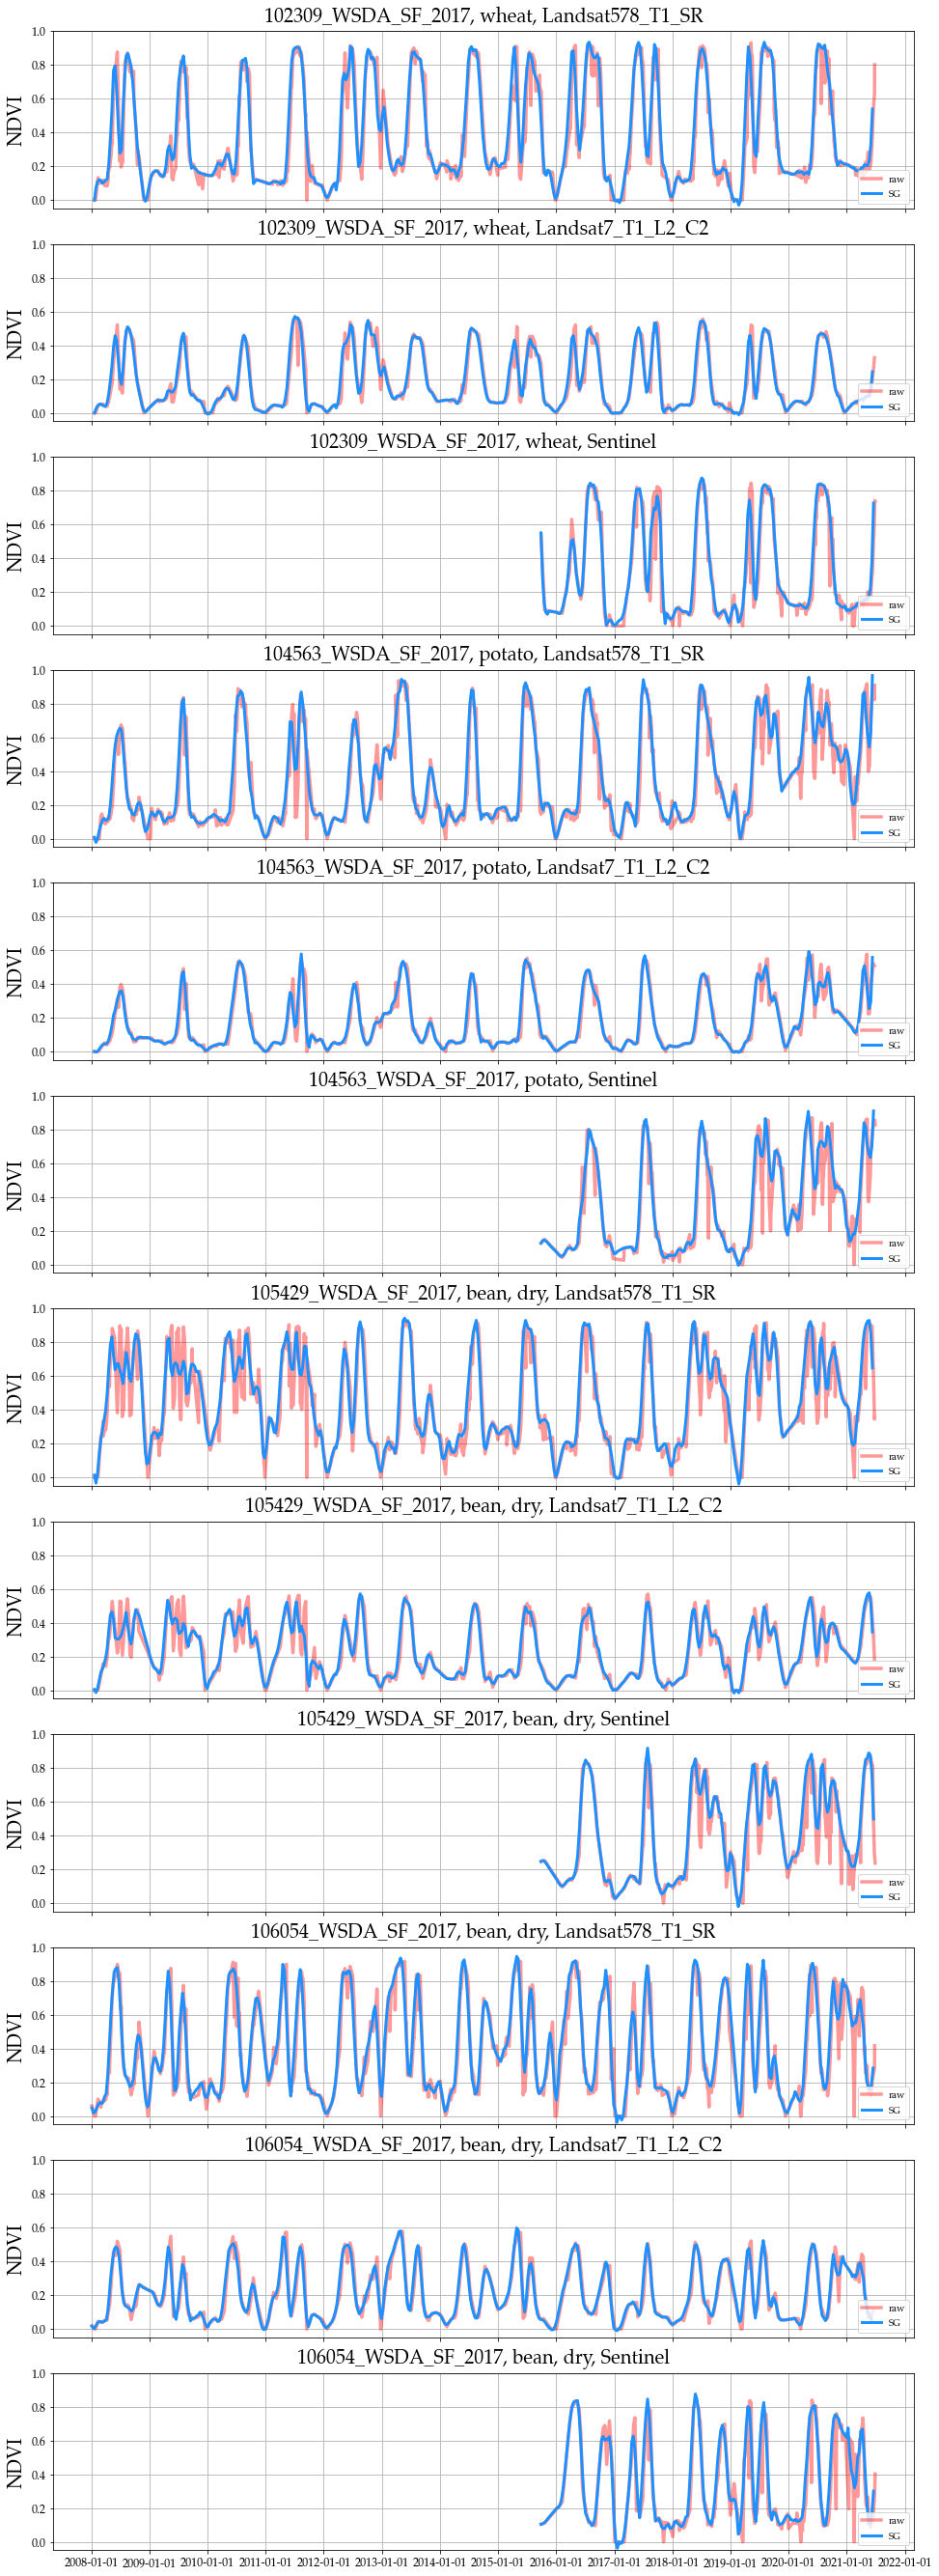

In [16]:
all_data.loc[all_data["NDVI"]<0 , "NDVI"] = 0

fig, axs = plt.subplots(12, 1, figsize=(16, 48),
                    sharex='col', sharey='row',
                    # sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0.2, 'wspace': .05});

(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12) = axs;
ax1.grid(True); ax2.grid(True)
ax3.grid(True); ax4.grid(True)

ax5.grid(True); ax7.grid(True)
ax6.grid(True); ax8.grid(True)

ax11.grid(True); ax12.grid(True)
ax9.grid(True); ax10.grid(True)

curr_raw = all_data[all_data.ID == ID_list[0]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[0]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax1, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[0]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[1]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax2, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[0]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[2]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax3, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[1]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[0]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax4, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[1]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[1]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax5, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[1]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[2]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax6, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[2]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[0]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax7, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[2]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[1]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax8, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[2]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[2]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax9, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[3]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[0]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax10, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[3]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[1]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax11, idx=VI, time_step_size=interval_size)

curr_raw = all_data[all_data.ID == ID_list[3]].copy()
curr_raw = curr_raw[curr_raw.dataset==satellite_list[2]].copy()
curr_raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
npc.plot_raw_and_regularized(raw_dt=curr_raw, ax=ax12, idx=VI, time_step_size=interval_size)

file_name = data_dir + "raw_figures/"+ "regularized_compare_Negatives_to_Zero.pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False);